In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

/Users/leahgaeta/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


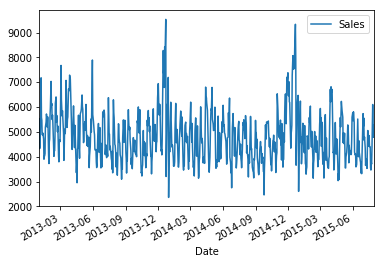

In [2]:
data = pd.read_csv('../dataset/rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

store1_data = data[data.Store == 1]

store1_open_data = store1_data[store1_data.Open == 1]

store1_open_data[['Sales']].plot()

In [5]:
print store1_open_data.Sales.autocorr(lag=1)
print store1_open_data.Sales.autocorr(lag=2)


0.682690824228
0.481217266146


These terms are high so shows some autocorrelation.  Indicates want to use AR model. 

/Users/leahgaeta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


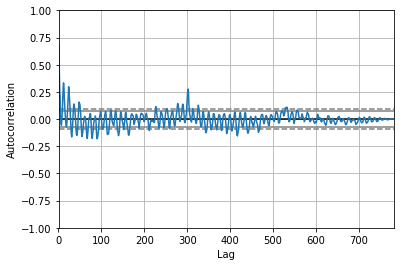

In [8]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_open_data.Sales)

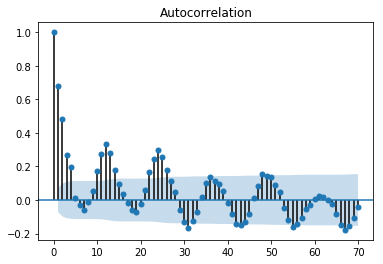

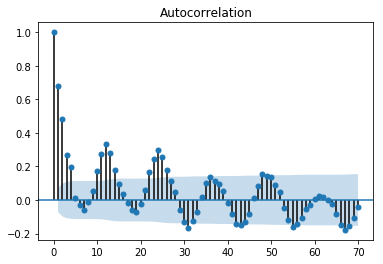

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(store1_open_data.Sales, lags=70)

In [13]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (1,0)).fit() #1 for autoregressive, 0 for no moving average
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Wed, 03 Jan 2018   AIC                          12540.651
Time:                        21:20:54   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.6173     82.986     57.391      0.000    4599.969    4925.266
ar.L1.Sales     0.6822      0.026     26.122      0.000       0.631       0.733
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4659           +0.0000j            1.4659            0.0000
-----------------------------------------------------------------------------
"""

Build and AR(1) model. Notice that the coefficient is the same as the autocorrelation at lag 1. Therefore, the assumptions that I started out with to do that derivation for autocorrelation = coefficient at lag 1 are true. Therefore, the series is stationary. (If less than one, then has to be same at autocorrelation value; if not then nonstationary but DOUBLE check this)

In [14]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
other_model = ARMA(store1_sales_data, (2,0)).fit() #2 for autoregressive, 0 for no moving average
other_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Wed, 03 Jan 2018   AIC                          12542.063
Time:                        21:21:06   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.3980     85.262     55.856      0.000    4595.287    4929.509
ar.L1.Sales     0.6634      0.036     18.537      0.000       0.593       0.734
ar.L2.Sales     0.0275      0.036      0.767      0.443      -0.043       0.098
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4235           +0.0000j            1.4235            0.0000
AR.2          -25.5833           +0.0000j           25.5833            0.5000
-----------------------------------------------------------------------------
"""

p value says that it's not significant; second coefficient isn't that big also; basically a (1,0) is just fine and don't need two previous data points

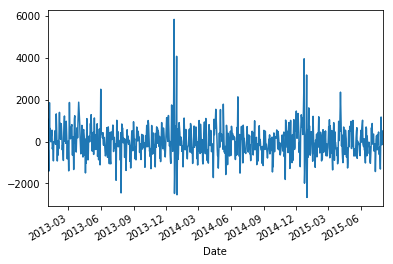

In [15]:
model.resid.plot()

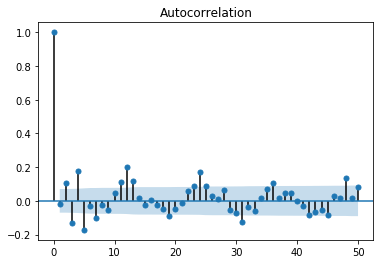

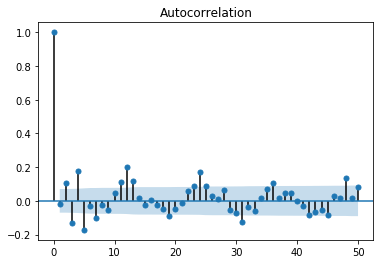

In [16]:
plot_acf(model.resid, lags=50)

In [17]:
new_model = ARMA(store1_sales_data, (1, 1)).fit()
new_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Wed, 03 Jan 2018   AIC                          12542.222
Time:                        21:23:38   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.5214     84.702     56.227      0.000    4596.509    4928.534
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654      0.514      -0.118       0.059
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4328           +0.0000j            1.4328            0.0000
MA.1           34.0022           +0.0000j           34.0022            0.0000
-----------------------------------------------------------------------------
"""

Shows one AR term and 1 MA term, can see that MA is small

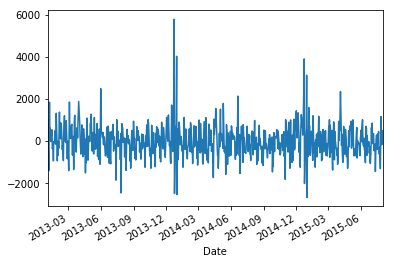

In [18]:
new_model.resid.plot()

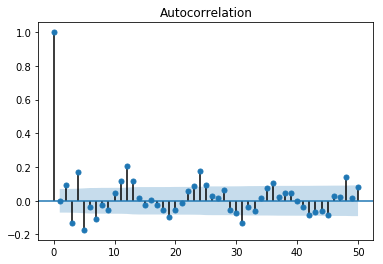

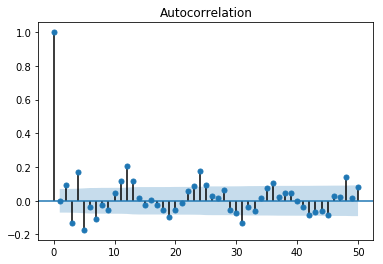

In [19]:
plot_acf(new_model.resid, lags=50)

In [21]:
from statsmodels.tsa.arima_model import ARIMA

#note that this isn't the open data, we'll get to that later
#also note that this is a nonseasonal model as well (not 2 p's, 2 d's, or 2 q's which would be for seasonal)
arima_model = ARIMA(store1_sales_data, (1, 1, 0)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6313.616
Method:                       css-mle   S.D. of innovations            792.680
Date:                Wed, 03 Jan 2018   AIC                          12633.233
Time:                        21:37:32   BIC                          12647.211
Sample:                    07-30-2015   HQIC                         12638.609
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2161     24.028      0.009      0.993     -46.877      47.309
ar.L1.D.Sales    -0.1815      0.035     -5.150      0.000      -0.251      -0.112
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.5103           +0.0000j            5.5103            0.5000
-----------------------------------------------------------------------------
"""

In [22]:
other_arima_model = ARIMA(store1_sales_data, (1, 1, 0)).fit()
other_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6313.616
Method:                       css-mle   S.D. of innovations            792.680
Date:                Wed, 03 Jan 2018   AIC                          12633.233
Time:                        21:40:08   BIC                          12647.211
Sample:                    07-30-2015   HQIC                         12638.609
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2161     24.028      0.009      0.993     -46.877      47.309
ar.L1.D.Sales    -0.1815      0.035     -5.150      0.000      -0.251      -0.112
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.5103           +0.0000j            5.5103            0.5000
-----------------------------------------------------------------------------
"""

In [23]:
store1_sales_data.Sales.diff(1).autocorr(1)


-0.18144101447610664

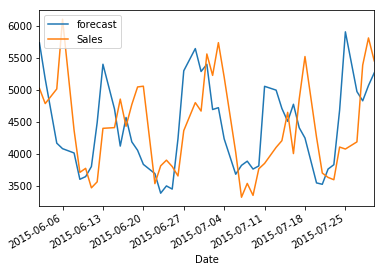

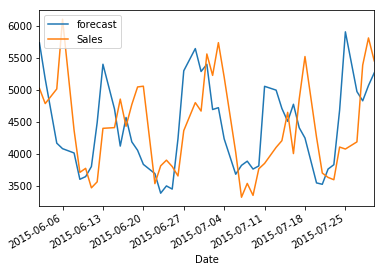

In [24]:
other_arima_model.plot_predict(1, 50)

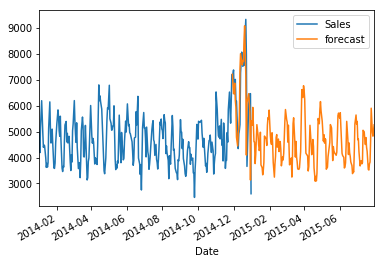

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)
fig = other_arima_model.plot_predict(1, 200, ax=ax, plot_insample=False)

In [26]:
#now fix model so taking into account only open stores
exog = store1_data.Open
store1_sales_data = store1_data[['Sales']].astype(float)

In [27]:
now_model = ARIMA(store1_sales_data, (1,0,1), exog=exog).fit()
now_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  942
Model:                     ARMA(1, 1)   Log Likelihood               -7558.266
Method:                       css-mle   S.D. of innovations            738.371
Date:                Wed, 03 Jan 2018   AIC                          15126.532
Time:                        21:50:52   BIC                          15150.772
Sample:                    07-31-2015   HQIC                         15135.772
                         - 01-01-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -188.2102     85.703     -2.196      0.028    -356.186     -20.235
Open         4987.5183     55.328     90.145      0.000    4879.078    5095.959
ar.L1.Sales     0.7558      0.031     24.713      0.000       0.696       0.816
ma.L1.Sales    -0.2628      0.042     -6.295      0.000      -0.345      -0.181
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3231           +0.0000j            1.3231            0.0000
MA.1            3.8058           +0.0000j            3.8058            0.0000
-----------------------------------------------------------------------------
"""

### Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


In [27]:
model = ARIMA(store1_sales_data, (7, 1, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -6221.636
Method:                       css-mle   S.D. of innovations            703.783
Date:                Wed, 27 Dec 2017   AIC                          12465.272
Time:                        11:10:55   BIC                          12516.524
Sample:                    07-30-2015   HQIC                         12484.984
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6853      4.555      0.150      0.880      -8.242       9.613
ar.L1.D.Sales     0.8404      0.211      3.982      0.000       0.427       1.254
ar.L2.D.Sales    -0.1503      0.145     -1.038      0.300      -0.434       0.134
ar.L3.D.Sales    -0.1831      0.046     -3.976      0.000      -0.273      -0.093
ar.L4.D.Sales     0.2557      0.060      4.296      0.000       0.139       0.372
ar.L5.D.Sales    -0.3381      0.067     -5.018      0.000      -0.470      -0.206
ar.L6.D.Sales     0.0691      0.074      0.931      0.352      -0.076       0.215
ar.L7.D.Sales    -0.0656      0.050     -1.325      0.185      -0.163       0.031
ma.L1.D.Sales    -1.1350      0.209     -5.443      0.000      -1.544      -0.726
ma.L2.D.Sales     0.2373      0.197      1.203      0.229      -0.149       0.624
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2128           -0.0000j            1.2128           -0.5000
AR.2            1.0141           -0.4950j            1.1285           -0.0723
AR.3            1.0141           +0.4950j            1.1285            0.0723
AR.4           -0.1357           -1.7545j            1.7597           -0.2623
AR.5           -0.1357           +1.7545j            1.7597            0.2623
AR.6            0.2547           -1.7666j            1.7848           -0.2272
AR.7            0.2547           +1.7666j            1.7848            0.2272
MA.1            1.1647           +0.0000j            1.1647            0.0000
MA.2            3.6180           +0.0000j            3.6180            0.0000
-----------------------------------------------------------------------------
"""

Figure(432x288)


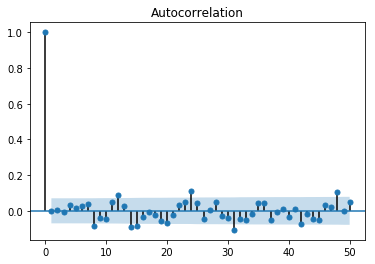

In [30]:
print plot_acf(model.resid, lags=50)

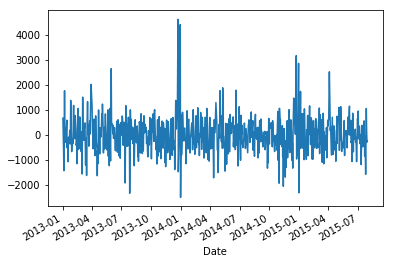

In [29]:
model.resid.plot()

#### Loading the data and setting the DateTimeIndex

In [ ]:
data = pd.read_csv('../dataset/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [ ]:
# TODO

#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

In [ ]:
# TODO

#### Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [ ]:
# TODO

In [ ]:
# TODO

In [ ]:
# TODO

#### Split the weekly sales data in a training and test set - using 75% of the data for training

In [ ]:
# TODO

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [ ]:
# TODO

#### Plot the residuals - where are their significant errors.

In [ ]:
# TODO

In [ ]:
# TODO

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [ ]:
# TODO

In [ ]:
# TODO

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [ ]:
# TODO